In [21]:
import sys
import os
import configparser
import csv
import numpy as np
import imageio
import torch
import torchvision
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import roc_curve, auc
from RetinaCheckerMultiClass import RetinaCheckerMultiClass
from helper_functions import reduce_to_2_classes, AverageMeter, AccuracyMeter
from make_default_config import get_config


In [26]:
# parameter
config = get_config()
config['network']['model'] = 'resnet18'
config['network']['pretrained'] = 'False'
config['network']['optimizer'] = 'Adam'
config['network']['criterion'] = 'BCEWithLogitsLoss'
config['network']['multiclass'] = 'True'

config['files']['test path'] = 'D:\\Dropbox\\Data\\mini-set'
config['input']['checkpoint'] = 'model-bin-example.ckpt'
config['input']['evaluation only'] = 'True'



In [27]:
    
rc = RetinaCheckerMultiClass()
rc.initialize( config )


Using device cpu


In [28]:
rc.load_state()

=> loaded checkpoint 'model-bin-example.ckpt' (epoch 1)


In [5]:
num_images = len(rc.test_loader.dataset)
n_cols = 6
n_rows = np.ceil(num_images/n_cols)
classlabel = ['no DMR', 'mild NPDR', 'mod NPDR', 'severe NPDR', 'PDR']
test_loader = torch.utils.data.DataLoader(dataset=rc.test_dataset,
                                        batch_size=len(rc.test_dataset),
                                        shuffle=False,
                                        sampler=None)

C:\Users\phili\Miniconda3\envs\torch\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


([], <a list of 0 Text yticklabel objects>)

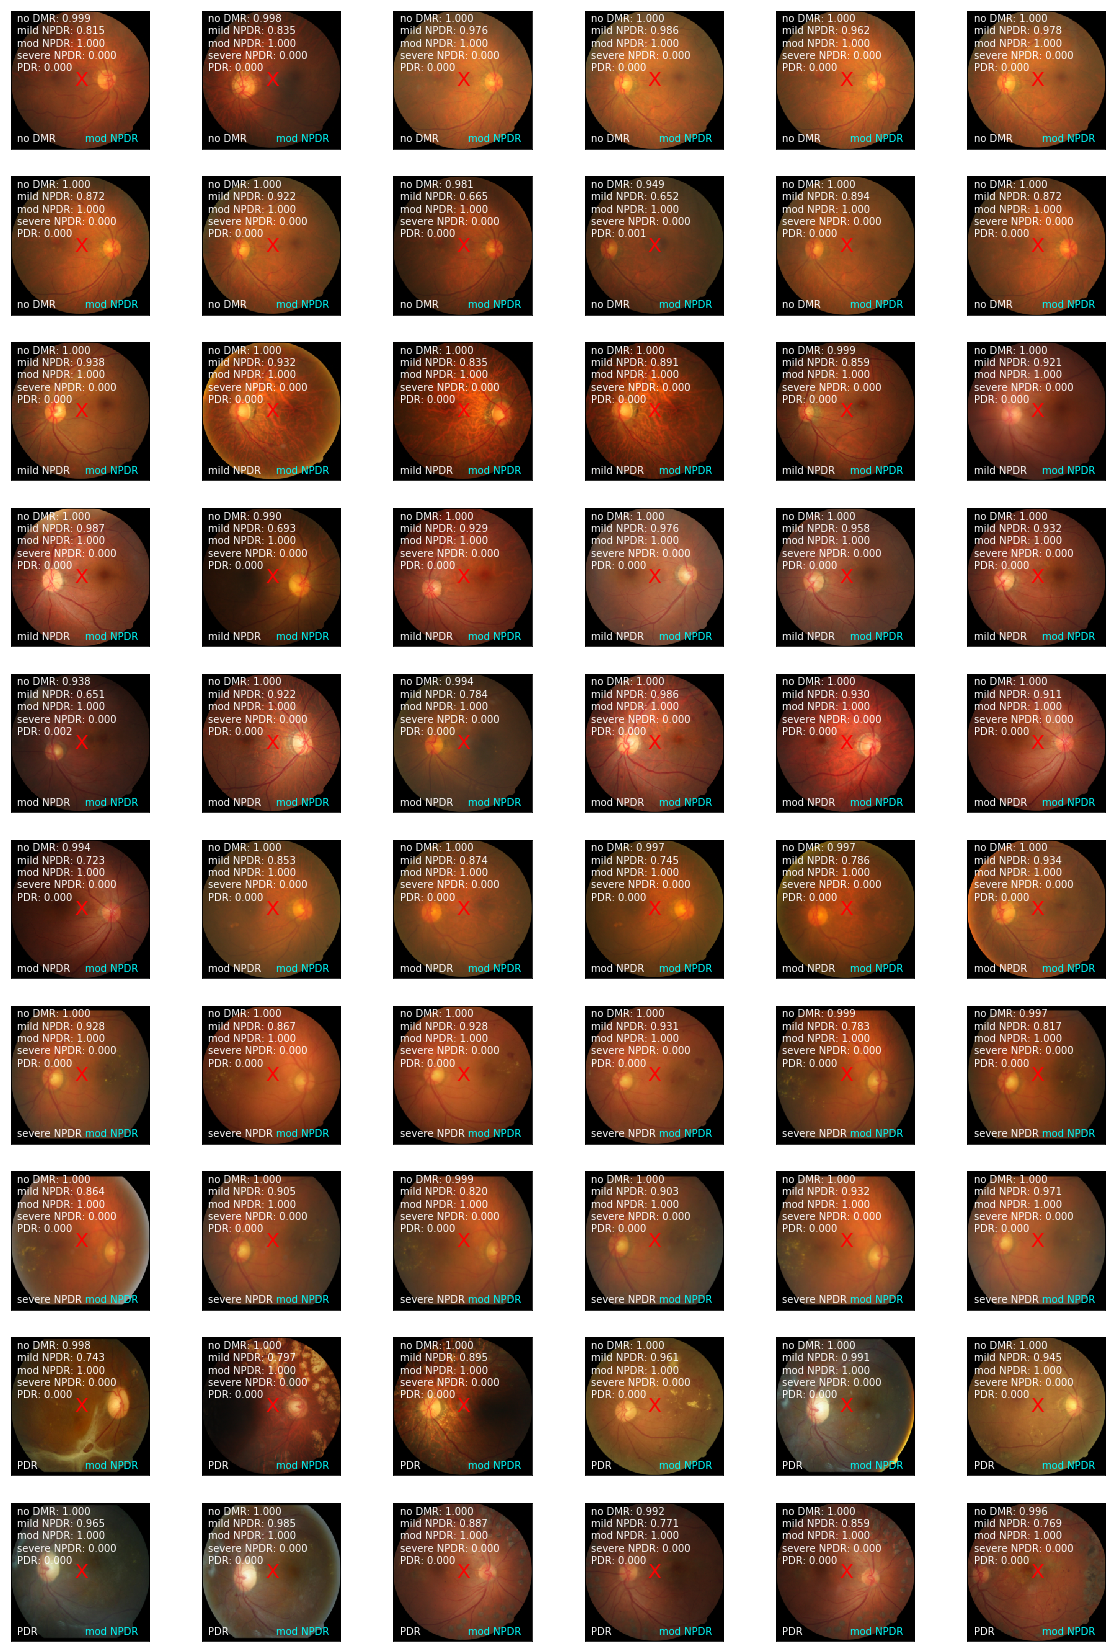

In [11]:
fig, ax = plt.subplots(int(n_rows), int(n_cols), True, True, figsize=(20,int(n_rows)*3))
rc.model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    losses = AverageMeter()
    accuracy = AccuracyMeter()

    confusion = torch.zeros((rc.num_classes, rc.num_classes), dtype=torch.float)
    counter = 0

    for images, labels in test_loader:
        images = images.to(rc.device)
        labels = labels.to(rc.device)

        outputs = rc.model(images)
        loss = rc.criterion(outputs, labels)

        losses.update(loss.item(), images.size(0))

        num_correct = rc._evaluate_performance( labels, outputs )

        accuracy.update(num_correct, labels.size(0))
        predicted = torch.nn.Sigmoid()(outputs)
        for pred, lab in zip(predicted.argmax(1), labels.argmax(1)):
            confusion[pred, lab] += 1
        
        for img, lab, out in zip(images, labels, outputs):
            ii = int(counter/n_cols)
            jj = int(counter%n_cols)
            img_array = skimage.transform.resize(imageio.imread(rc.test_dataset.imgs[counter][0]), (224,224), mode='constant', anti_aliasing=True)
            ax[ii, jj].imshow(img_array, origin='lower')
            ax[ii, jj].annotate( classlabel[lab.argmax()], xy=(10,10), color='white', size=10)
            ax[ii, jj].annotate( classlabel[out.argmax()], xy=(120,10), color='cyan', size=10)
            if lab.argmax != out.argmax():
                ax[ii, jj].annotate( 'X', xy=(102,102), color='red', size=20)
            for cc in range(5):
                ax[ii, jj].annotate( '{}: {:.3f}'.format(classlabel[cc], torch.nn.Sigmoid()(out[cc])) , xy=(10,205-cc*20), color='white', size=10)
            counter+=1

plt.xticks([])
plt.yticks([])



In [12]:
print('Test Accuracy of the model on the {} test images: {} %'.format(accuracy.count, accuracy.avg*100))
print('Classes: {}'.format(rc.classes))
print('Confusion matrix:\n', (confusion))

confusion_2class = reduce_to_2_classes( confusion, [(0,1), (2,3,4)])
print('Accuracy: {:.1f}%'.format(np.diag(confusion_2class).sum()/confusion_2class.sum()*100))
print(confusion_2class)
print('Sensitivity: {:.1f}%'.format(confusion_2class[1,1]/confusion_2class[:,1].sum()*100))
print('Specificity: {:.1f}%'.format(confusion_2class[0,0]/confusion_2class[:,0].sum()*100))

Test Accuracy of the model on the 60 test images: 4.0 %
Classes: {'0_noDMR': 0, '1_mildNPDR': 1, '2_modNPDR': 2, '3_severe_NPDR': 3, '4_PDR': 4}
Confusion matrix:
 tensor([[ 1.,  2.,  1.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.],
        [11., 10., 11., 12., 10.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])
Accuracy: 60.0%
[[ 3.  3.]
 [21. 33.]]
Sensitivity: 91.7%
Specificity: 12.5%


In [13]:
y_test = labels.cpu().numpy()
y_score = torch.nn.Sigmoid()(outputs).cpu().numpy()
n_classes = 5

In [14]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

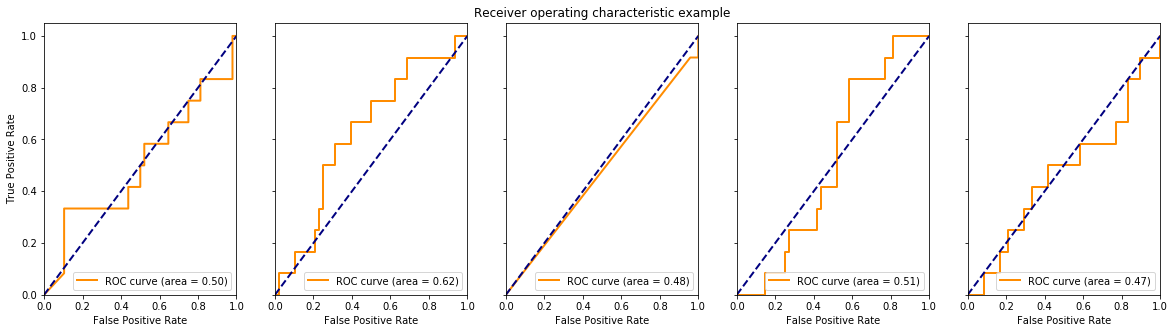

In [15]:
fig, ax = plt.subplots(1, n_classes, True, True, figsize=(20,5))
lw = 2
for ii in range(n_classes):
    ax[ii].plot(fpr[ii], tpr[ii], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[ii])
    ax[ii].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[ii].set_xlim([0.0, 1.0])
    ax[ii].set_ylim([0.0, 1.05])
    ax[ii].set_xlabel('False Positive Rate')
    ax[ii].legend(loc="lower right")

ax[0].set_ylabel('True Positive Rate')
ax[int(n_classes/2)].set_title('Receiver operating characteristic example')
plt.show()

In [20]:
predicted.argmax(0)

tensor([ 3, 52,  0, 24, 24])